# Parse mutation data for frequency plots.

Input files: Breseq output annotated.gd (tab-delimited text) files for generations 100, 300, 500, 780, 1000 of evolution line UA3.

## A. Plot frequencies of accepted and rejected polymorphisms across genome positions.

In [1]:
import numpy as np
import pandas as pd
import re
UA3_100 = pd.read_table('/Users/ymseah/Documents/sic_UA3-15_breseq/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_100.insert(0, 'generation', 100)
UA3_300 = pd.read_table('/Users/ymseah/Documents/sic_UA3.45_breseq/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_300.insert(0, 'generation', 300)
UA3_500 = pd.read_table('/Users/ymseah/Documents/sic_UA3-76_breseq/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_500.insert(0, 'generation', 500)
UA3_780 = pd.read_table('/Users/ymseah/Documents/sic_UA3.118_breseq/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_780.insert(0, 'generation', 780)
UA3_1000 = pd.read_table('/Users/ymseah/Documents/sic_UA3_S2_L001_breseq/output/evidence/annotated.gd', comment='#', names=range(50), dtype=str)
UA3_1000.insert(0, 'generation', 1000)

In [2]:
UA3_df  = pd.concat([UA3_100, UA3_300, UA3_500, UA3_780, UA3_1000], ignore_index=True)
UA3_df.insert(0, 'line', 'UA3')
UA3_df.insert(2, 'frequency', 0.0)
UA3_df.insert(3, 'gene_product', '')
UA3_df.insert(4, 'reject', '')

In [3]:
for row in UA3_df.itertuples():
    #check each column
    col_index = 6
    while col_index < 50:
        #1. polymorphism frequencies
        if re.match('frequency=', str(UA3_df.loc[row[0], col_index])):
            UA3_df.loc[row[0], 'frequency'] = re.sub('frequency=', '', str(UA3_df.loc[row[0], col_index]))
        #2. gene products
        elif re.match('gene_product=', str(UA3_df.loc[row[0], col_index])):
            UA3_df.loc[row[0], 'gene_product'] = re.sub('gene_product=', '', str(UA3_df.loc[row[0], col_index]))
        #3. polymorphism rejection reasons
        elif re.match('reject=', str(UA3_df.loc[row[0], col_index])):
            UA3_df.loc[row[0], 'reject'] = re.sub('reject=', '', str(UA3_df.loc[row[0], col_index]))
        col_index += 1
    #set frequencies type to float
    if re.match('1|2|3|4|5|6|7|8|9', str(UA3_df.loc[row[0], 'frequency'])):
        UA3_df.loc[row[0], 'frequency'] = float(UA3_df.loc[row[0], 'frequency'])
    else:
        UA3_df.loc[row[0], 'frequency'] = 0.0
    #set positions (col 4) type to int
    UA3_df.loc[row[0], 4] = int(UA3_df.loc[row[0], 4])
    #set reject col to 'NA' when no reject reason given.
    if (UA3_df.loc[row[0], 'reject'] == '') & (UA3_df.loc[row[0], 2] == '.'):
        UA3_df.loc[row[0], 'reject'] = 'NA'

In [4]:
UA3_df.rename(columns = {4:'position'}, inplace=True)

DvH_UA3_nonzero = UA3_df[(UA3_df[3] == 'NC_002937') & (UA3_df['frequency'] > 0) & (UA3_df['reject'] != 'NA')]
DvHplasmid_UA3_nonzero = UA3_df[(UA3_df[3] == 'NC_005863') & (UA3_df['frequency'] > 0) & (UA3_df['reject'] != 'NA')]
MmS2_UA3_nonzero = UA3_df[(UA3_df[3] == 'NC_005791') & (UA3_df['frequency'] > 0) & (UA3_df['reject'] != 'NA')]

In [5]:
from bokeh.charts import output_notebook, show, Bar

#Data for plotting DvH (accepted AND rejected mutations)
DvH_UA3_plotting = DvH_UA3_nonzero[['position', 'generation', 'gene_product', 'frequency', 'reject']]

#Generate figure inline
output_notebook()
DvH_UA3_fig = Bar(DvH_UA3_plotting, 'position', values = 'frequency', stack = 'generation', 
                  width = 800, height = 400, tools = 'xpan, xzoom_in, xzoom_out', 
                  title = 'D. vulgaris Hildenborough mutation frequencies', legend = 'top_right')
show(DvH_UA3_fig)

Loading BokehJS ...

In [6]:
from bokeh.charts import output_notebook, show, Bar

#Data for plotting DvH plasmid (accepted AND rejected mutations)
DvHplasmid_UA3_plotting = DvHplasmid_UA3_nonzero[['position', 'generation', 'gene_product', 'frequency', 'reject']]

#Generate figure inline
output_notebook()
DvHplasmid_UA3_fig = Bar(DvHplasmid_UA3_plotting, 'position', values = 'frequency', stack = 'generation', 
                  width = 800, height = 400, tools = 'xpan, xzoom_in, xzoom_out', 
                  title = 'D. vulgaris Plasmid mutation frequencies', legend = 'top_right')
show(DvHplasmid_UA3_fig)

Loading BokehJS ...

In [ ]:
from bokeh.charts import output_notebook, show, Bar

#Data for plotting MmS2 (accepted AND rejected mutations)
MmS2_UA3_plotting = MmS2_UA3_nonzero[['position', 'generation', 'gene_product', 'frequency', 'reject']]

#Generate figure inline
output_notebook()
MmS2_UA3_fig = Bar(MmS2_UA3_plotting, 'position', values = 'frequency', stack = 'generation', 
                  width = 800, height = 400, tools = 'xpan, xzoom_in, xzoom_out', 
                  title = 'M. maripaludis S2 mutation frequencies', legend = 'top_right')
show(MmS2_UA3_fig)

Loading BokehJS ...

## B. Plot mutation frequencies grouped by gene function.

## Problems & Solutions
### 1. Inconsistent number of columns in gdiff output files raises error with pandas read_table() function.
Solution 1: Table headers need to be specified with read_table(names=[]) to assign NaN to "missing" column values.

Solution 2: Use index.html output instead, parse into data structure acceptable by pandas.

In [263]:
#This is Solution 2
import re
from bs4 import BeautifulSoup
soup = BeautifulSoup(open('/Users/ymseah/Documents/sic_UA3_S2_L001_breseq/output/index.html'), 'html5lib')

#EXAMPLE ROW
#<tr class="normal_table_row">
#<td align="center"><a href="evidence/INS_1.html">RA</a></td><!-- Evidence -->
#<td align="center">NC_002937</td><!-- Seq_Id -->
#<td align="right">42,867</td><!-- Position -->
#<td align="center">+G</td><!-- Cell Mutation -->
#<td align="right">100%</td>
#<td align="center">intergenic (‑125/+57)</td>
#<td align="center"><i>DVU0036</i> ← / ← <i>DVU0037</i></td>
#<td align="left">hypothetical protein/hypothetical protein</td>
#</tr>

#get each consensus mode row 
tr_consensus = soup('tr', 'normal_table_row')
cons_ref_genome = [tr.find_all_next('td')[1].text for tr in tr_consensus]
cons_mutation_pos = [tr.find_all_next('td')[2].text for tr in tr_consensus]
cons_mutation = [tr.find_all_next('td')[3].text for tr in tr_consensus]
cons_freq = [tr.find_all_next('td')[4].text for tr in tr_consensus]

#get each polymorphism mode row
tr_polymorphism = soup('tr', 'polymorphism_table_row')
polym_ref_genome = [tr.find_all_next('td')[1].text for tr in tr_polymorphism]
polym_mutation_pos = [tr.find_all_next('td')[2].text for tr in tr_polymorphism]
polym_mutation = [tr.find_all_next('td')[3].text for tr in tr_polymorphism]
polym_freq = [tr.find_all_next('td')[4].text for tr in tr_polymorphism]

ref_genome = cons_ref_genome + polym_ref_genome

mutation_pos = cons_mutation_pos + polym_mutation_pos
clean_mutation_pos = []
i = 0
while i < len(mutation_pos):
    clean_position = re.sub(',', '', mutation_pos[i])
    clean_mutation_pos.append(int(clean_position))
    i += 1

freq = cons_freq + polym_freq
clean_freqs = []
i = 0
while i < len(freq):
    clean_freq = re.sub('%', '', freq[i])
    clean_freqs.append(float(clean_freq))
    i += 1

mutation_freq_dict = {'genome': ref_genome, 'position': clean_mutation_pos, 'frequency': clean_freqs}

In [264]:
import numpy as np
import pandas as pd
df = pd.DataFrame(mutation_freq_dict)
DvH = df.loc[df['genome'] == 'NC_002937']
#DvHplasmid = df.loc[df['genome'] == 'NC_005863']
MmS2 = df.loc[df['genome'] == 'NC_005791']

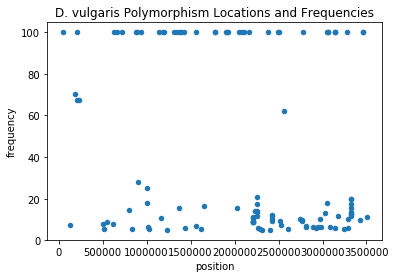

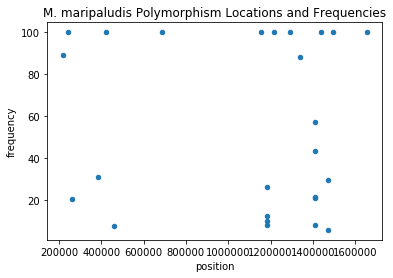

In [265]:
import matplotlib.pyplot as plt
DvH.plot.scatter(x = 'position', y = 'frequency')
plt.title('D. vulgaris Polymorphism Locations and Frequencies')
plt.show()
MmS2.plot.scatter(x = 'position', y = 'frequency')
plt.title('M. maripaludis Polymorphism Locations and Frequencies')
plt.show()

## 2. Polymorphism frequencies, etc. are not consistently in the same column.

Solution: Use regex matching across rows.

In [ ]:
for row in UA3_100.itertuples():
    #check each column for polymorphism frequencies
    i = 6
    while i < 50:
        if re.match('frequency=', str(UA3_100.loc[row[0], i])):
            UA3_100.loc[row[0], 'frequency'] = re.sub('frequency=', '', str(UA3_100.loc[row[0], i]))
        i += 1
    if re.match('1|2|3|4|5|6|7|8|9', str(UA3_100.loc[row[0], 'frequency'])):
        UA3_100.loc[row[0], 'frequency'] = float(UA3_100.loc[row[0], 'frequency'])
    else:
        UA3_100.loc[row[0], 'frequency'] = 0.0
    #change position (col4) type to int for plotting
    UA3_100.loc[row[0], 4] = int(UA3_100.loc[row[0], 4])
UA3_100.rename(columns = {4:'position'}, inplace=True)

## 3. Plot mutations by position

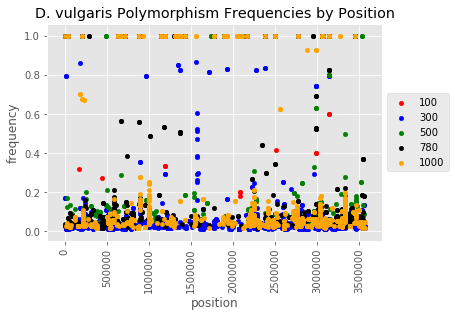

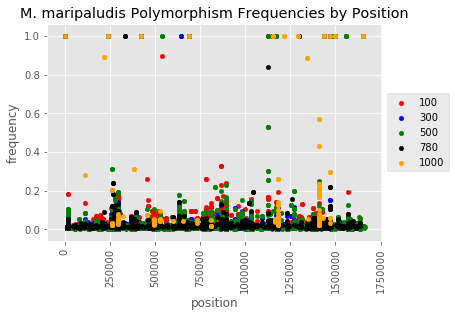

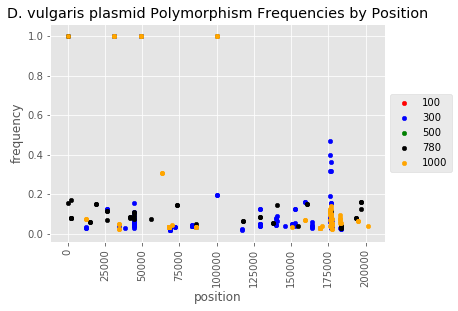

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

DvH_UA3_gen = DvH_UA3_nonzero.groupby('generation')
DvHplasmid_UA3_gen = DvHplasmid_UA3_nonzero.groupby('generation')
MmS2_UA3_gen = MmS2_UA3_nonzero.groupby('generation')
colors = {100: 'red', 300: 'blue', 500: 'green', 780: 'black', 1000: 'orange'}

fig, ax = plt.subplots()
for generation, mut in DvH_UA3_gen:
    mut.plot.scatter(x = 'position', y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation])
plt.title('D. vulgaris Polymorphism Frequencies by Position')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax = plt.subplots()
for generation, mut in MmS2_UA3_gen:
    mut.plot.scatter(x = 'position', y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation])
plt.title('M. maripaludis Polymorphism Frequencies by Position')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax = plt.subplots()
for generation, mut in DvHplasmid_UA3_gen:
    mut.plot.scatter(x = 'position', y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation])
plt.title('D. vulgaris plasmid Polymorphism Frequencies by Position')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


## 4. Differentiate accepted/rejected mutations, zoom in.

In [197]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#if 'reject' column = '.', line is denoting evidence (RA/JC/MC/UN), not polymorphism.
DvH_UA3_rejected = DvH_UA3_nonzero[(DvH_UA3_nonzero['reject'] != '') & (DvH_UA3_nonzero['reject'] != '.')]
DvHplasmid_UA3_rejected = DvHplasmid_UA3_nonzero[(DvHplasmid_UA3_nonzero['reject'] != '') & (DvHplasmid_UA3_nonzero['reject'] != '.')]
MmS2_UA3_rejected = MmS2_UA3_nonzero[(MmS2_UA3_nonzero['reject'] != '') & (MmS2_UA3_nonzero['reject'] != '.')]

#if 'reject' column = '', is accepted polymorphism.
DvH_UA3_accepted = DvH_UA3_nonzero[DvH_UA3_nonzero['reject'] == '']
DvHplasmid_UA3_accepted = DvHplasmid_UA3_nonzero[DvHplasmid_UA3_nonzero['reject'] == '']
MmS2_UA3_accepted = MmS2_UA3_nonzero[MmS2_UA3_nonzero['reject'] == '']

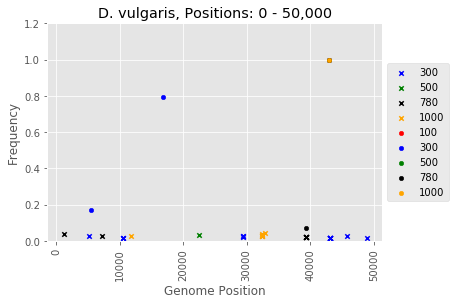

In [198]:
#zoom in on DvH first 50,000 bases
DvH_UA3_rejected_50k = DvH_UA3_rejected[DvH_UA3_rejected[4] <= 50000]
DvH_UA3_accepted_50k = DvH_UA3_accepted[DvH_UA3_accepted[4] <= 50000]
DvH_UA3_rejected_50k_gen = DvH_UA3_rejected_50k.groupby('generation')
DvH_UA3_accepted_50k_gen = DvH_UA3_accepted_50k.groupby('generation')

colors = {100: 'red', 300: 'blue', 500: 'green', 780: 'black', 1000: 'orange'}

fig, ax = plt.subplots()
#plot rejected and accepted polymorphisms
for generation, mut in DvH_UA3_rejected_50k_gen:
    mut.plot.scatter(x = 4, y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation], marker = 'x')
for generation, mut in DvH_UA3_accepted_50k_gen:
    mut.plot.scatter(x = 4, y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation], marker = 'o')
plt.title('D. vulgaris, Positions: 0 - 50,000')
plt.xlabel('Genome Position')
plt.ylabel('Frequency')
plt.ylim(0,1.2)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

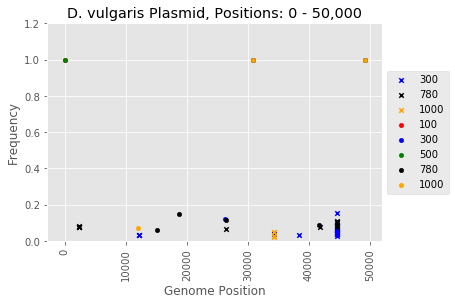

In [199]:
#zoom in on DvH plasmid first 50,000 bases
DvHplasmid_UA3_rejected_50k = DvHplasmid_UA3_rejected[DvHplasmid_UA3_rejected[4] <= 50000]
DvHplasmid_UA3_accepted_50k = DvHplasmid_UA3_accepted[DvHplasmid_UA3_accepted[4] <= 50000]
DvHplasmid_UA3_rejected_50k_gen = DvHplasmid_UA3_rejected_50k.groupby('generation')
DvHplasmid_UA3_accepted_50k_gen = DvHplasmid_UA3_accepted_50k.groupby('generation')

fig, ax = plt.subplots()
#plot rejected and accepted polymorphisms
for generation, mut in DvHplasmid_UA3_rejected_50k_gen:
    mut.plot.scatter(x = 4, y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation], marker = 'x')
for generation, mut in DvHplasmid_UA3_accepted_50k_gen:
    mut.plot.scatter(x = 4, y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation], marker = 'o')
plt.title('D. vulgaris Plasmid, Positions: 0 - 50,000')
plt.xlabel('Genome Position')
plt.ylabel('Frequency')
plt.ylim(0,1.2)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

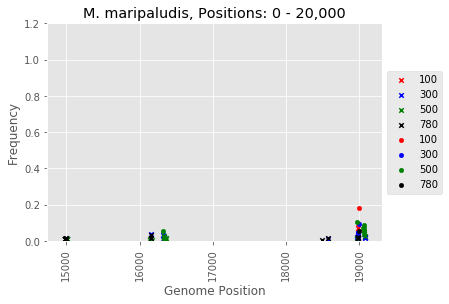

In [200]:
#zoom in on MmS2 first 20,000 bases
MmS2_UA3_rejected_20k = MmS2_UA3_rejected[MmS2_UA3_rejected[4] <= 20000]
MmS2_UA3_accepted_20k = MmS2_UA3_accepted[MmS2_UA3_accepted[4] <= 20000]
MmS2_UA3_rejected_20k_gen = MmS2_UA3_rejected_20k.groupby('generation')
MmS2_UA3_accepted_20k_gen = MmS2_UA3_accepted_20k.groupby('generation')

fig, ax = plt.subplots()
#plot rejected and accepted polymorphisms
for generation, mut in MmS2_UA3_rejected_20k_gen:
    mut.plot.scatter(x = 4, y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation], marker = 'x')
for generation, mut in MmS2_UA3_accepted_20k_gen:
    mut.plot.scatter(x = 4, y = 'frequency', rot=90, ax = ax, label = generation, color = colors[generation], marker = 'o')
plt.title('M. maripaludis, Positions: 0 - 20,000')
plt.xlabel('Genome Position')
plt.ylabel('Frequency')
plt.ylim(0,1.2)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))